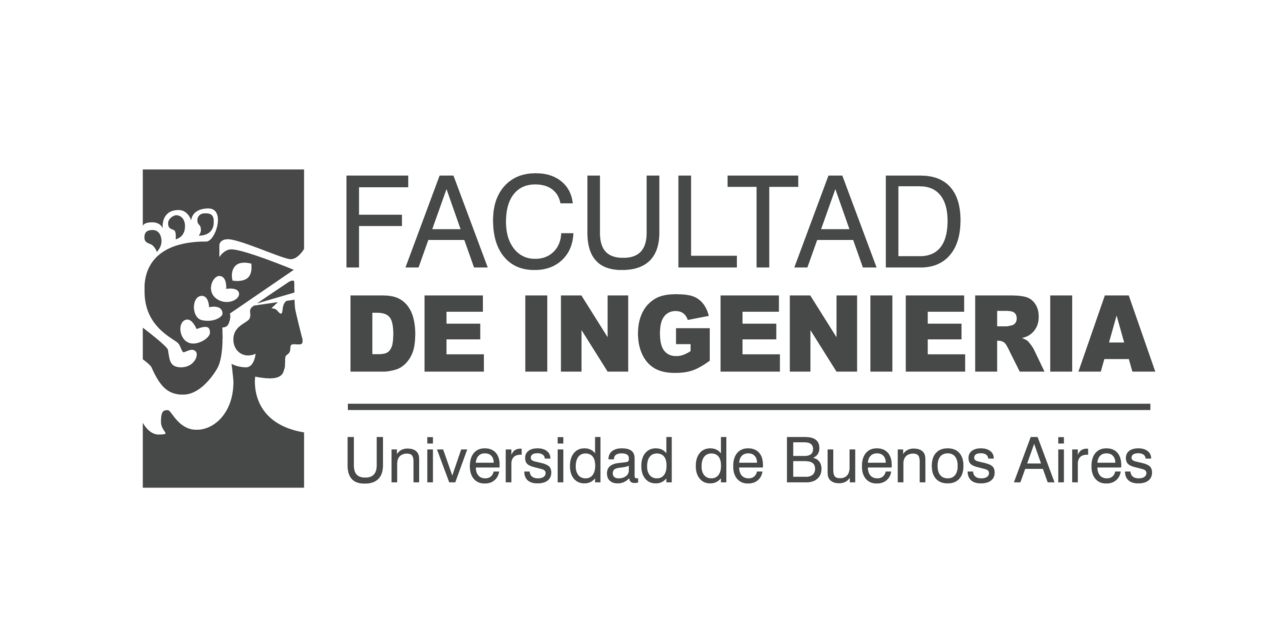

**Profesor:** <br />
Dr. Ing. Facundo Adrián Lucianna

**Alumnos:** <br />
Ing. Pablo Martin Gomez Verdini - gomezpablo86@gmail.com <br />
Ing. Diego Paciotti Iacchelli - diegopaciotti@gmail.com  <br />
Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/FIUBA-CEIA-18Co2024/IIA-TP3 <br />


## TP3: Detector de SPAM

### Introducción y consigna

Uno de los problemas más comunes en la clasificación es la detección de correos electrónicos SPAM. Uno de los primeros modelos utilizados para abordar este problema fue el clasificador de Bayes ingenuo. La detección de SPAM es un problema persistente en el mundo digital, ya que los spammers continúan adaptando sus estrategias para eludir los filtros de correo no deseado. Además del clasificador de Bayes ingenuo, se han desarrollado y utilizado una variedad de técnicas más avanzadas en la detección de SPAM, que incluyen algoritmos de aprendizaje automático, redes neuronales y métodos basados en reglas.

En este trabajo práctico, utilizaremos un conjunto de datos que consta de 4601 observaciones de correos electrónicos, de los cuales 2788 son correos legítimos y 1813 son correos SPAM. Dado que el contenido de los correos electrónicos es un tipo de dato no estructurado, es necesario procesarlo de alguna manera. Para este conjunto de datos, ya se ha aplicado un procesamiento típico en el Procesamiento del Lenguaje Natural (NLP), que consiste en contar la frecuencia de palabras observadas en los correos.

El procesamiento de lenguaje natural (NLP) desempeña un papel fundamental en la detección de SPAM, ya que permite analizar el contenido de los correos electrónicos y extraer características relevantes para la clasificación. Además de contar la frecuencia de palabras, se pueden utilizar técnicas más sofisticadas, como la extracción de características semánticas y el análisis de sentimientos, para mejorar la precisión de los modelos de detección de SPAM.

En este proceso, se cuenta la cantidad de ocurrencias de cada palabra en los diferentes correos.

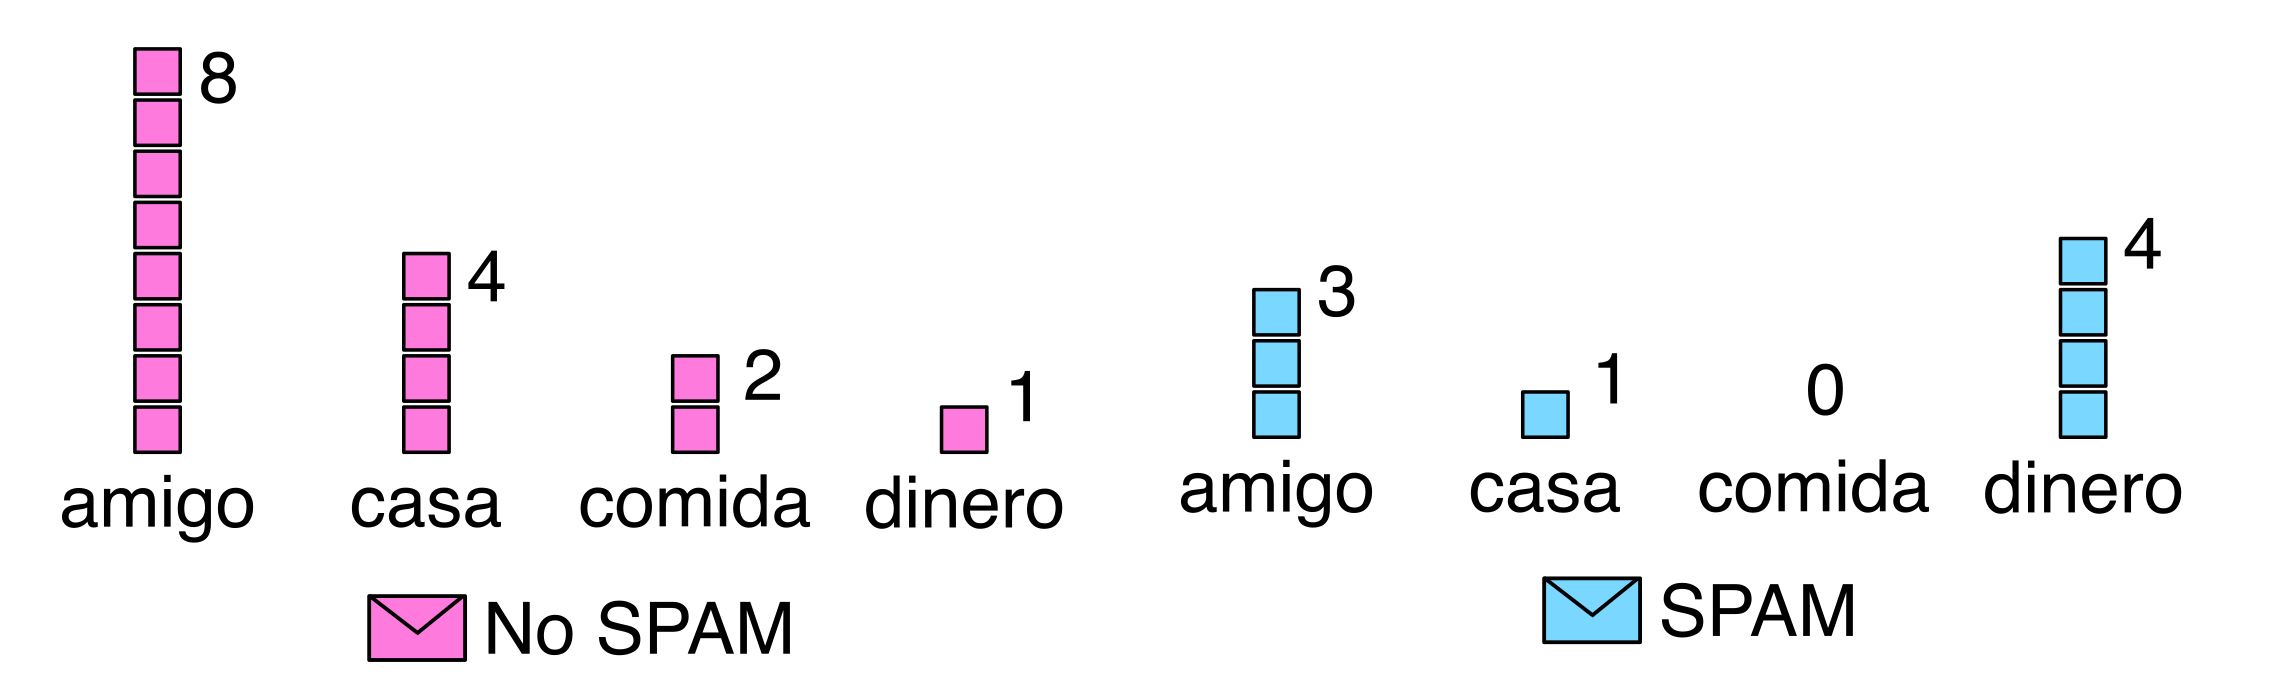

Con el fin de preservar la privacidad de los mensajes, la frecuencia de palabras se encuentra normalizada. El conjunto de datos está compuesto por 54 columnas de atributos que se denominan:

- `word_freq_XXXX`: Donde `XXXX` es la palabra o símbolo. Los valores son enteros que van de 0 a 20k.

Además, hay una columna adicional llamada `spam`, que es 1 si el correo es SPAM o 0 si no lo es.

Los clasificadores de Bayes ingenuos fueron los primeros filtros utilizados por las aplicaciones de correo electrónico, basados en este principio de palabras. La idea es que, partiendo de un dato a priori sobre la probabilidad de que un correo sea SPAM o no, ciertas palabras nos indicarán que la probabilidad a posteriori, dadas esas palabras, es más probable que el correo sea SPAM o no.

1. ¿Cuáles son las 10 palabras más encontradas en correos con SPAM y en correos No SPAM? ¿Hay palabras en común? ¿Algunas llaman la atención?
2. Separe el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba (70% y 30% respectivamente).
3. Utilizando un clasificador de Bayes ingenuo, entrene con el conjunto de entrenamiento.
4. Utilizando un clasificador de Regresión Logística, entrene con el conjunto de entrenamiento (en este caso, normalice los datos).
5. Calcule la matriz de confusión del conjunto de evaluación para ambos modelos. ¿Qué tipo de error comete más cada modelo? ¿Cuál de los dos tipos de error crees que es más importante para este problema?
6. Calcule la precisión y la recuperación de ambos modelos. Para cada métrica, ¿cuál es el mejor modelo? ¿Cómo se relacionan estas métricas con los tipos de errores analizados en el punto anterior? Expanda su respuesta.
7. Obtenga la curva ROC y el AUC (Área Bajo la Curva ROC) de ambos modelos.

### Utilidades y requerimientos

In [117]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.naive_bayes import MultinomialNB   
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
                                accuracy_score,
                                precision_score,
                                recall_score,
                                confusion_matrix,
                                ConfusionMatrixDisplay,
                                f1_score, 
                                roc_auc_score,
                                auc, 
                                roc_curve
)

In [119]:
def display_cm_normalized(cm, model):
    # Normalize the confusion matrix
    cm_normalized = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot the confusion matrix with percentages
    fig, ax = plt.subplots()
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['No SPAM', 'SPAM'], yticklabels=['No SPAM', 'SPAM'],
           title='Normalized Confusion Matrix '+str(model),
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations
    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm_normalized[i, j]:{fmt}}%",
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

### Carga de datos, exploración y normalización

In [120]:
dataset = pd.read_csv("dataset/spambase.csv")
display(dataset.head(5))
display(dataset.shape)
display(dataset['spam'].value_counts())

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,spam
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,778,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,132,0,372,180,48,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,10,143,0,276,184,10,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,137,0,137,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,135,0,135,0,0,1


(4601, 55)

spam
0    2788
1    1813
Name: count, dtype: int64

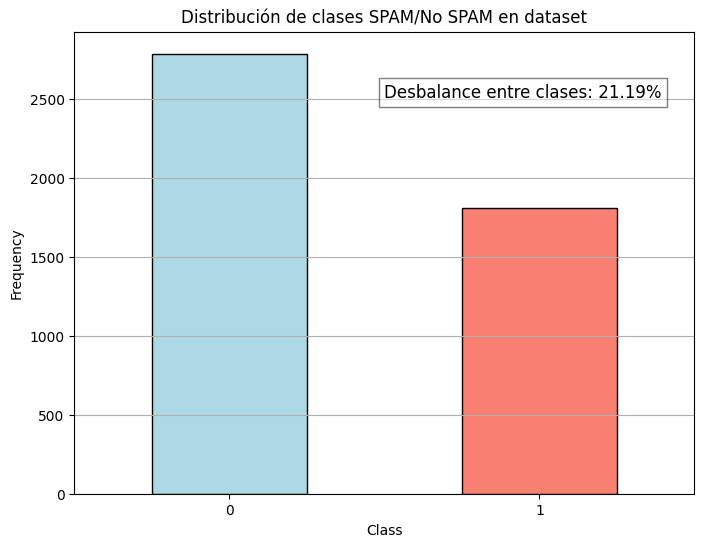

In [121]:
dataset_plot = dataset.copy()
dataset_plot['spam'] = dataset_plot['spam'].map({0: 'Non-Spam', 1: 'Spam'})

# Calculamos porcentaje de desbalance
class_counts = dataset_plot['spam'].value_counts()
total_count = class_counts.sum()
class_percentage = (class_counts / total_count) * 100
imbalance_percentage = abs(class_percentage['Spam'] - class_percentage['Non-Spam'])


plt.figure(figsize=(8, 6))
dataset['spam'].value_counts().plot(kind='bar', color=['lightblue', 'salmon'], edgecolor='black')
plt.title('Distribución de clases SPAM/No SPAM en dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.text(0.5, max(class_counts) * 0.9, f'Desbalance entre clases: {imbalance_percentage:.2f}%', 
         ha='left', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

Para obtener las palábras más usadas podemos hacer un `groupby`:

In [122]:
column_sum = dataset.groupby(by="spam", as_index=False).sum()
display(column_sum)

,spam,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#
0,0,204860,681569,559220,2470,504739,124190,26160,107100,106080,...,1159138,800669,22840,142820,140182,442116,63242,306634,32475,60536
1,1,276190,298510,732080,298550,931799,317050,499309,377360,308320,...,226790,26700,2210,3810,37299,197563,14864,931352,316328,143003


Se escalan por 100 las columnas de word_freq y separan columnas de features con target

In [123]:
X = (dataset.drop(columns="spam") * 100).astype(int)
y = dataset["spam"]

### Desarrollo

#### 1. ¿Cuáles son las 10 palabras más encontradas en correos con SPAM y en correos No SPAM? ¿Hay palabras en común? ¿Algunas llaman la atención?

In [124]:
no_spam_top10 = column_sum.iloc[0].nlargest(10)
spam_top10 = column_sum.iloc[1].nlargest(10)

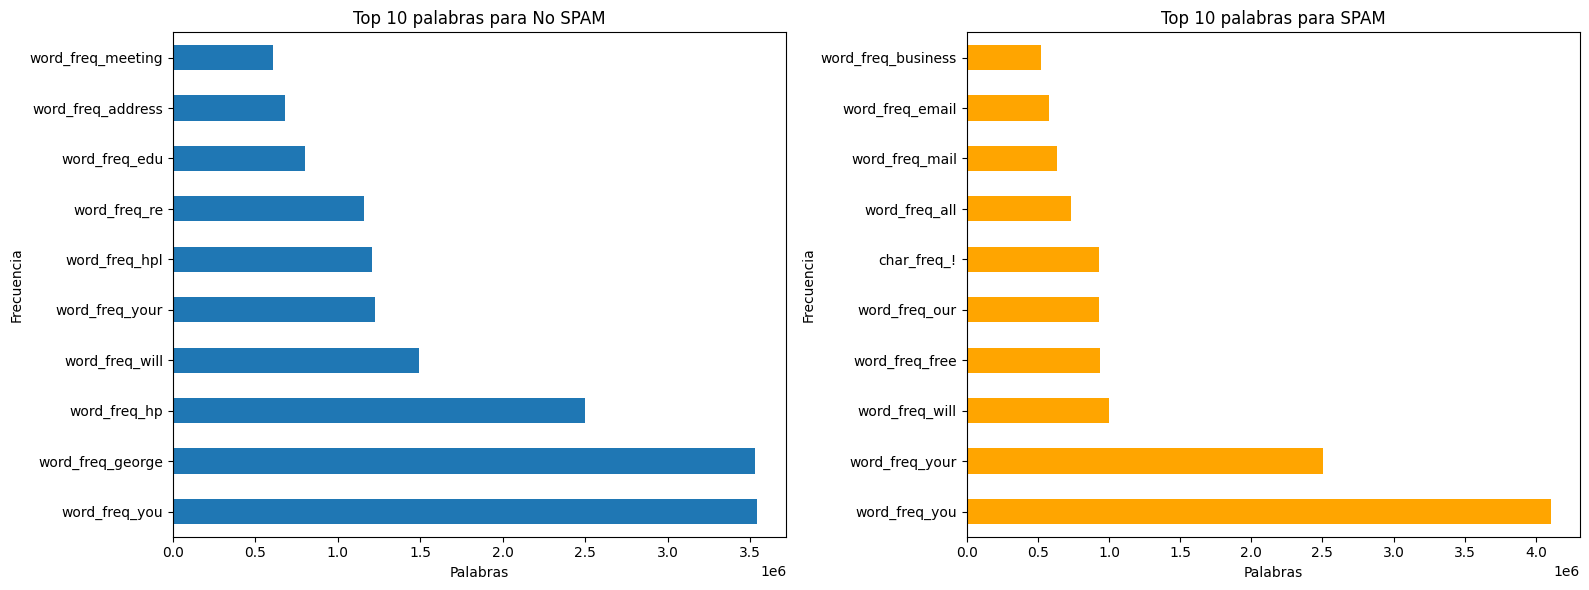

In [125]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
no_spam_top10.plot(kind='barh')
plt.title('Top 10 palabras para No SPAM')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

# Plotting the top 10 words for "SPAM"
plt.subplot(1, 2, 2)
spam_top10.plot(kind='barh', color='orange')
plt.title('Top 10 palabras para SPAM')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

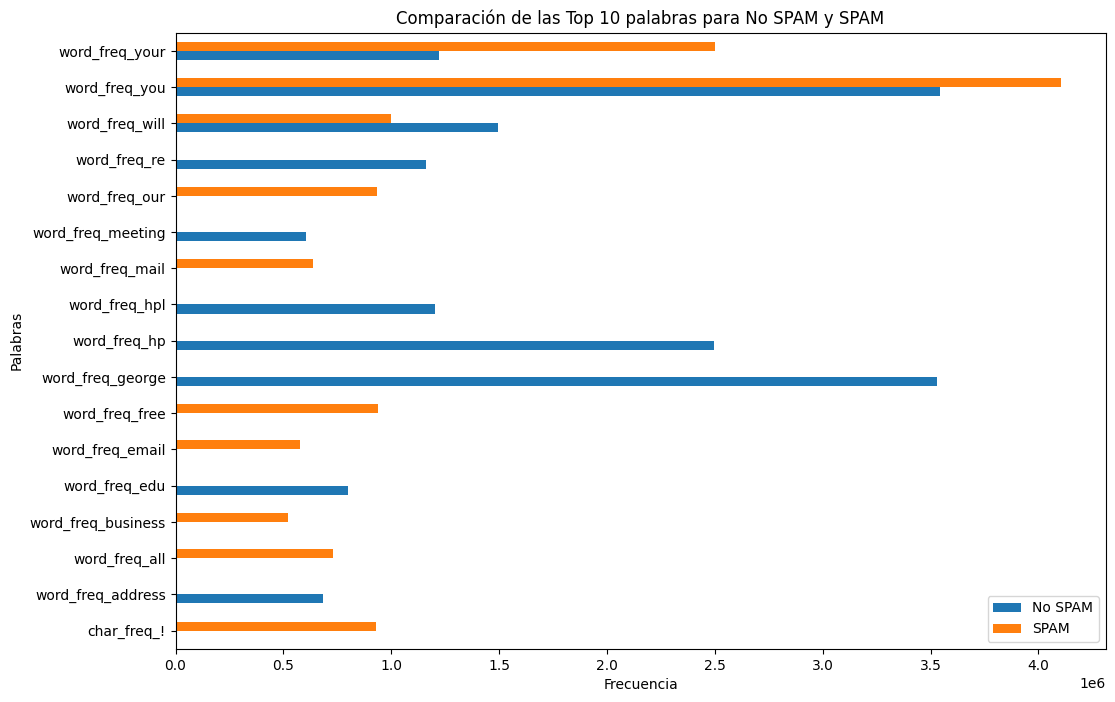

In [126]:
no_spam_top10 = column_sum.iloc[0].nlargest(10)
spam_top10 = column_sum.iloc[1].nlargest(10)

combined_top10 = pd.DataFrame({
    'No SPAM': no_spam_top10,
    'SPAM': spam_top10
}).fillna(0) 

# Plotting the combined data
combined_top10.plot(kind='barh', figsize=(12, 8))
plt.title('Comparación de las Top 10 palabras para No SPAM y SPAM')
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.show()

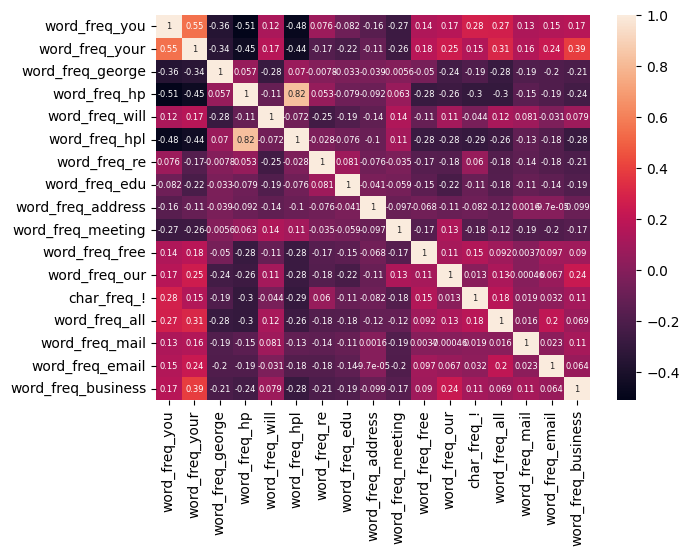

In [127]:
# Veamos la correlación cruzada entre los elementos que surgen de la 
# combinación de las 10 palabras más encontradas en correos SPAM y no SPAM.
plt.figure(figsize=(7, 5))
default_profit = dataset[
    [
        "word_freq_you",
        "word_freq_your",
        "word_freq_george",
        "word_freq_hp",
        "word_freq_will",
        "word_freq_hpl",
        "word_freq_re",
        "word_freq_edu",
        "word_freq_address",
        "word_freq_meeting",
        "word_freq_free",
        "word_freq_our",
        "char_freq_!",
        "word_freq_all",
        "word_freq_mail",
        "word_freq_email",
        "word_freq_business"
    ]
].corr(numeric_only=True).round(2)
sns.heatmap(data=default_profit.corr(), annot=True, annot_kws={"size": 6});

Nos interesa armar un heatmap con la matriz de correlación de las features que mas correlación tienen dado un threshold. Esto será especialmente util para el modelo Naive Bayes elegido (MultinomialNB) ya que este mismo supone nula correlación o independencia entre feature, y de no cumpirse podría ser motivo de baja performance.

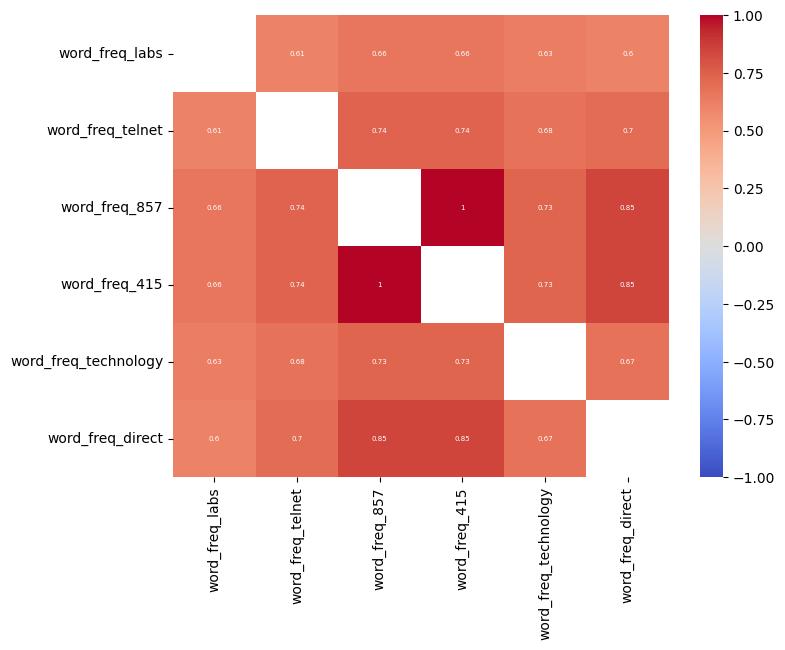

In [128]:
threshold = 0.6

# Calculamos matriz de correlación
corr_matrix = dataset.corr()
filtered_corr = corr_matrix.where(np.abs(corr_matrix) > threshold)
# Dropeamos columnas con NaN (below threshold)
np.fill_diagonal(filtered_corr.values, np.nan)
filtered_corr = filtered_corr.dropna(how='all').dropna(axis=1, how='all')
# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 5}, mask=filtered_corr.isnull())

plt.show()

#### 2. Separe el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba (70% y 30% respectivamente).

In [129]:
random_state = 12345
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y, shuffle=True)

display(dataset['spam'].value_counts())
display(y_train.value_counts())
display(y_test.value_counts())

spam
0    2788
1    1813
Name: count, dtype: int64

spam
0    1951
1    1269
Name: count, dtype: int64

spam
0    837
1    544
Name: count, dtype: int64

Escalamos para aplicar en regresión logística

In [130]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo transformamos en DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

#### 3. Utilizando un clasificador de Bayes ingenuo, entrene con el conjunto de entrenamiento.

MultinomialNB es un buen modelo de la familia de clasificadores bayesianos para count-based features como pueden ser las word_frequencies de los mails que serán utilizadas para clasificar de spam o no al mensaje. Asume distribuciones multinomiales en las clases e independencia entre las features.

De no cumplirse algunas de las consideraciones del modelo, o de tener mucho desbalance de clases, su performance podría verse afectada. En el caso puntual de clases desbalanceadas, el modelo podría tener problemas con la clase minoritaria por el peso y sesgo dado durante entrenamiento de la clase mayoritaria.

In [131]:
X_train.head(4)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#
804,0,56000,28000,0,0,0,56000,0,0,56000,...,28000,0,0,0,0,11800,0,15800,0,15800
1494,76000,38000,0,0,38000,38000,0,0,0,38000,...,0,0,0,0,0,12400,0,12400,0,6200
2570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4563,54000,0,54000,0,54000,0,0,0,0,0,...,0,109000,0,0,0,0,9700,0,0,0


In [132]:
bayes_naive = MultinomialNB()
bayes_naive.fit(X_train, y_train)   # Entrenamos con los datos sin escalar.
print(f"Porcentaje de muestras bien clasificadas: {(bayes_naive.score(X_test, y_test)*100)}%")

Porcentaje de muestras bien clasificadas: 86.60391020999276%


In [133]:
y_test_pred_bn = bayes_naive.predict(X_test) 

In [134]:
df_compare = pd.DataFrame({'True Label': y_test, 'Predicted Label': y_test_pred_bn})
df_compare = df_compare[df_compare['True Label'] != df_compare['Predicted Label']]
print(f"Cantidad de clasificaciones incorrectas (0: no_spam | 1: spam): {df_compare['Predicted Label'].value_counts()}")

Cantidad de clasificaciones incorrectas (0: no_spam | 1: spam): Predicted Label
1    163
0     22
Name: count, dtype: int64


#### 4. Utilizando un clasificador de Regresión Logística, entrene con el conjunto de entrenamiento (en este caso, normalice los datos).

In [135]:
regresion_logistica = LogisticRegression()
regresion_logistica.fit(X_train_scaled, y_train) # Entrenamos con los valores escalados

print(f"Porcentaje de muestras bien clasificadas: {(regresion_logistica.score(X_test, y_test)*100)}%")

Porcentaje de muestras bien clasificadas: 80.59377262853005%


In [136]:
y_test_pred_rl = regresion_logistica.predict(X_test_scaled)

#### 5. Calcule la matriz de confusión del conjunto de evaluación para ambos modelos. ¿Qué tipo de error comete más cada modelo? ¿Cuál de los dos tipos de error crees que es más importante para este problema?

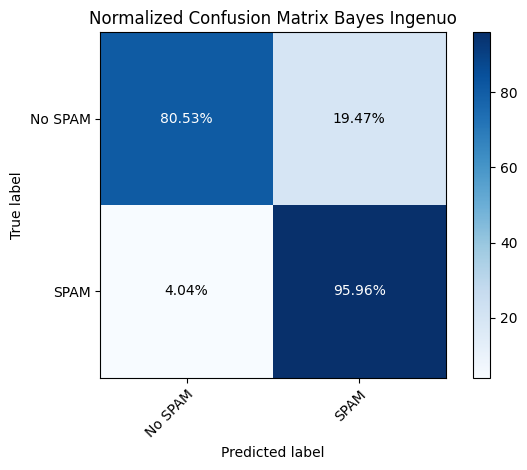

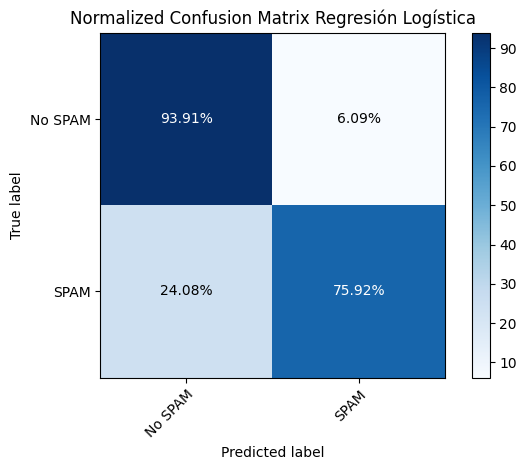

In [137]:
cm_nv = confusion_matrix(y_test, y_test_pred_bn)
cm_rl = confusion_matrix(y_test, y_test_pred_rl)

display_cm_normalized(cm_nv, 'Bayes Ingenuo')
display_cm_normalized(cm_rl, "Regresión Logística")

Para el caso de la matriz de confusión se toma por defecto valor True Positive al superior izquierdo. En este caso seria positivo los valores No SPAM que fueron clasificados como tal. 
1. Un Falso Positivo o error Tipo 1 en el contexto del problema son los correos No SPAM que fueron clasificados como SPAM. En el contexto del problema este es el peor caso, ya que se puede haber perdido un correo mal clasificado que era importante.
2. Un Falso Negativo o error Tipo 2 en el contexto del problema son los correos SPAM, que se clasificaron como No SPAM. En este contexto esto no es tan grave como perder mails importantes, ya que en todo caso se tienen algunos SPAM en la bandeja de entrada.

En este caso el mejor modelo es el Regresión Logística.

#### 6. Calcule la precisión y la recuperación de ambos modelos. Para cada métrica, ¿cuál es el mejor modelo? ¿Cómo se relacionan estas métricas con los tipos de errores analizados en el punto anterior? Expanda su respuesta.

In [138]:
from sklearn.metrics import precision_score, recall_score

print("------------------------------")
print("Modelo Bayes Ingenuo")
print(f"Precisión: {precision_score(y_test, y_test_pred_bn, zero_division=0, pos_label=1)}")
print(f"Recuperación: {recall_score(y_test, y_test_pred_bn, zero_division=0, pos_label=1)}")
print("------------------------------")
print("Modelo Regresión Logística")
print(f"Precisión: {precision_score(y_test, y_test_pred_rl, zero_division=0, pos_label=1)}")
print(f"Recuperación: {recall_score(y_test, y_test_pred_rl, zero_division=0, pos_label=1)}")

------------------------------
Modelo Bayes Ingenuo
Precisión: 0.762043795620438
Recuperación: 0.9595588235294118
------------------------------
Modelo Regresión Logística
Precisión: 0.8900862068965517
Recuperación: 0.7591911764705882


* Para el caso de los scores a nosotros nos interesa clasificar como positivo a los valores de SPAM con pos_label=1
    * La precisión es intuitivamente la capacidad del clasificador de no etiquetar como positiva una muestra que es negativa.
    * La recuperación es intuitivamente la capacidad del clasificador de encontrar todas las muestras positivas.

* El modelo de Regresión Logística muestra mejor precisión, lo que se veía en la matriz de confusión, ya que clasifica menos mail No SPAM como SPAM.
* El modelo de Bayes Ingenuo entrenado con los datos sin escalar parece ser mejor en clasificar los mails como SPAM en general.


#### 7. Obtenga la curva ROC y el AUC (Área Bajo la Curva ROC) de ambos modelos.

##### 7.1: ROC y AUC

In [139]:
# X_test deberia ser ya que estamos distorcionando el modelo al escalar las features, MB usa frecuencia/conteos ya normalizados
# probar calibracion o esto deberia explicarse por no independencia de variables como se ve en la matriz de correlacion, tal vez
# se podria probar sacar algunas con alta correlacion y probar el modelo
prob_nb = bayes_naive.predict_proba(X_test)[:, -1]
prob_lr = regresion_logistica.predict_proba(X_test_scaled)[:, -1]

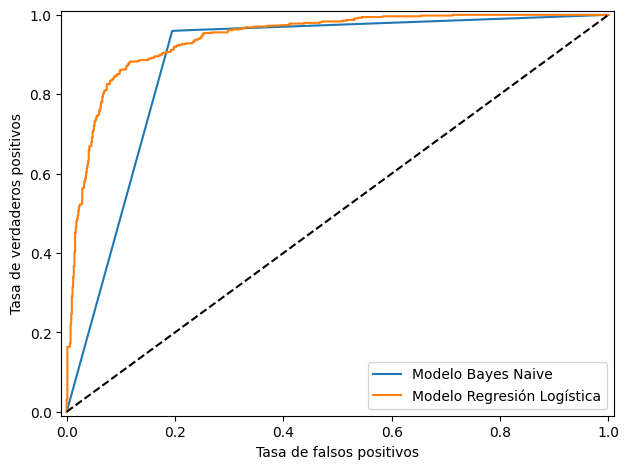

In [140]:
fpr_bayes_naive, tpr_bayes_naive, _ = roc_curve(y_test, prob_nb)
fpr_regresion_logistica, tpr_regresion_logistica, _ = roc_curve(y_test, prob_lr)

plt.plot(fpr_bayes_naive, tpr_bayes_naive, label="Modelo Bayes Naive")
plt.plot(fpr_regresion_logistica, tpr_regresion_logistica, label="Modelo Regresión Logística")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.legend()
plt.tight_layout();

La curva ROC nos permite ver para todo valor de umbral, los dos tipos de errores. En el eje de las abscisas se utiliza la tasa de falsos positivos (o 1-especificidad) y en la ordenada la tasa de verdadero positivos (sensibilidad).\
La curva se obtiene midiendo la sensibilidad y la especificad para todos los valores de umbrales de 0 a 1.

Se puede explicar esa curva para MultinomialNB debido a que no se cumple la premisa que da por cierta MNNB que es la independencia de las features como se puede ver en la matriz de correlación.

##### 7.2: Metricas

In [141]:
y_nb_predict = bayes_naive.predict(X_test)
y_regresion_logistica_predict = regresion_logistica.predict(X_test)

y_nb_accuracy = accuracy_score(y_test, y_nb_predict)
y_nb_f1 = f1_score(y_test, y_nb_predict)
y_nb_recall = recall_score(y_test, y_nb_predict)

y_regresion_logistica_accuracy = accuracy_score(y_test, y_regresion_logistica_predict)
y_regresion_logistica_f1 = f1_score(y_test, y_regresion_logistica_predict)
y_regresion_logistica_recall = recall_score(y_test, y_regresion_logistica_predict)

print(f"Modelo Bayes Ingenuo AUC: {auc(fpr_bayes_naive, tpr_bayes_naive)}")
print(f"Accuracy of MultinomialNB model: {y_nb_accuracy * 100:.2f}%")
print(f"F1-score of MultinomialNB model: {y_nb_f1:.2f}")
print(f"Recall of MultinomialNB model: {y_nb_recall:.2f}")
print('--------')
print(f"Modelo Regresión Logística AUC: {auc(fpr_regresion_logistica, tpr_regresion_logistica)}")
print(f"Accuracy of Regresion Logistica model: {y_regresion_logistica_accuracy * 100:.2f}%")
print(f"F1-score of Regresion Logistica model: {y_regresion_logistica_f1:.2f}")
print(f"Recall of Regresion Logistica model: {y_regresion_logistica_recall:.2f}")

Modelo Bayes Ingenuo AUC: 0.8825198538196641
Accuracy of MultinomialNB model: 86.60%
F1-score of MultinomialNB model: 0.85
Recall of MultinomialNB model: 0.96
--------
Modelo Regresión Logística AUC: 0.9409282978424346
Accuracy of Regresion Logistica model: 80.59%
F1-score of Regresion Logistica model: 0.80
Recall of Regresion Logistica model: 0.98


El modelo de Regresión Logística con los datos escalados funciona mejor según la AUC, tiene mejor poder de clasificación.

##### 7.3: Selección de features con KBest

Usamos **SelectKBest** que selecciona las k features más importantes de un conjunto de datos en función de un criterio específico (una función de scoring). Esto puede ser útil para reducir la dimensionalidad de los datos, mejorar la interpretabilidad del modelo y, en algunos casos, aumentar el rendimiento del modelo al enfocarse en las features mas relevantes.

Para cada feature, SelectKBest calcula un score utilizando una función de puntuación. En este caso usaremos **Chi-cuadrado (chi2)** para medir la dependencia entre las features y el target que es comúnmente utilizado en problemas de clasificación.

El analisis lo haremos primero sin kbest, es decir, con las features originales del dataset y luego con las features seleccionadas solamente.

Analizamos cual es la mejor cantidad de features utilizando KBest

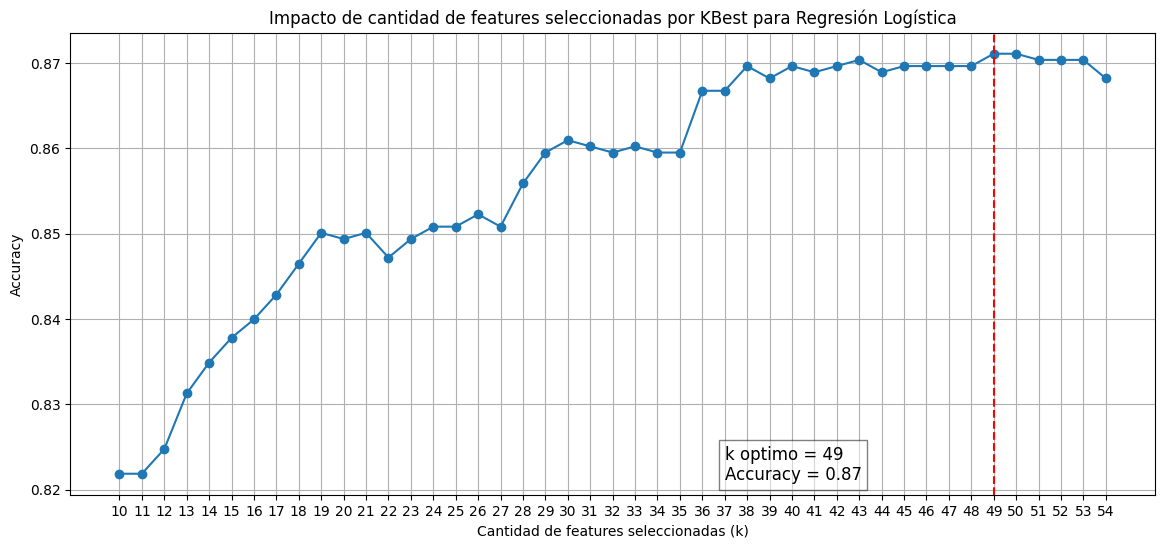

In [142]:
k_values = [i for i in range(10,55)]
accuracies = []
model = None 
k_values = [i for i in range(10, 55)]

for k in k_values:
    del model
    # Apply SelectKBest with chi-squared
    selector = SelectKBest(score_func=chi2, k=k)
    X_train_k_scaled = selector.fit_transform(X_train_scaled, y_train)
    X_test_k_scaled = selector.transform(X_test_scaled)

    # Train MultinomialNB on the selected features
    model = LogisticRegression()
    model.fit(X_train_k_scaled, y_train)

    # Predict on the test set and calculate accuracy
    y_pred = model.predict(X_test_k_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

max_accuracy_index = np.argmax(accuracies)
optimal_k = k_values[max_accuracy_index]
optimal_accuracy = accuracies[max_accuracy_index]

# Plotting the accuracies against k values
plt.figure(figsize=(14, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Impacto de cantidad de features seleccionadas por KBest para Regresión Logística')
plt.xlabel('Cantidad de features seleccionadas (k)')
plt.ylabel('Accuracy')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k: {optimal_k} (Accuracy: {optimal_accuracy:.2f})')
plt.xticks(k_values)
textstr = f'k optimo = {optimal_k}\nAccuracy = {optimal_accuracy:.2f}'
plt.text(optimal_k - 12, optimal_accuracy - 0.05, textstr, bbox=dict(facecolor='white', alpha=0.5), fontsize=12)

plt.grid()

plt.show()

In [143]:
k = 49  # numero de features a seleccionar f_classif
selector = SelectKBest(score_func=chi2, k=k)

X_train_kbest = selector.fit_transform(X_train_scaled, y_train)
X_test_kbest = selector.transform(X_test_scaled)

# Obtenemos listado de features filtradas
selected_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_indices]
all_features = X_train.columns
removed_features = all_features.difference(selected_features)

print(f"Cantidad de Features removidas: {len(removed_features)}\nFeatures removidas por KBest: {removed_features}")
print(f"Features seleccionadas por KBest: {selected_features}")

Cantidad de Features removidas: 5
Features removidas por KBest: Index(['char_freq_[', 'word_freq_address', 'word_freq_parts',
       'word_freq_report', 'word_freq_will'],
      dtype='object')
Features seleccionadas por KBest: Index(['word_freq_make', 'word_freq_all', 'word_freq_3d', 'word_freq_our',
       'word_freq_over', 'word_freq_remove', 'word_freq_internet',
       'word_freq_order', 'word_freq_mail', 'word_freq_receive',
       'word_freq_people', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_pm',
       'word_freq_direct', 'word_freq_cs', 'word_freq_

##### 7.4: Conclusiones y comparación entre los 3 modelos

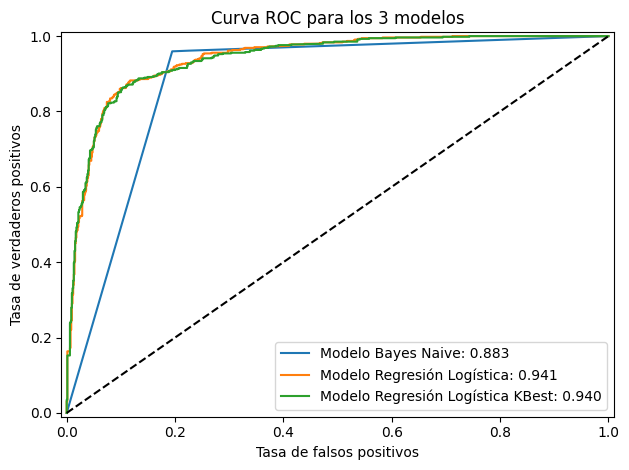

In [144]:
del model
model = LogisticRegression()
model.fit(X_train_kbest, y_train)

y_pred = model.predict(X_test_kbest)
y_prob = model.predict_proba(X_test_kbest)[:, -1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
fpr_bayes_naive, tpr_bayes_naive, _ = roc_curve(y_test, prob_nb)
fpr_regresion_logistica, tpr_regresion_logistica, _ = roc_curve(y_test, prob_lr)


plt.plot(fpr_bayes_naive, tpr_bayes_naive, label=f"Modelo Bayes Naive: {auc(fpr_bayes_naive, tpr_bayes_naive):.3f}")
plt.plot(fpr_regresion_logistica, tpr_regresion_logistica, label=f"Modelo Regresión Logística: {auc(fpr_regresion_logistica, tpr_regresion_logistica):.3f}")
plt.plot(fpr, tpr, label=f"Modelo Regresión Logística KBest: {auc(fpr, tpr):.3f}")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.title("Curva ROC para los 3 modelos")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.plot([0, 1], [0, 1], 'k--')

plt.legend()
plt.tight_layout();

In [145]:
y = model.predict(X_test_kbest)
y_nb_predict = bayes_naive.predict(X_test)
y_regresion_logistica_predict = regresion_logistica.predict(X_test_scaled)

# Logit KBest
y_accuracy = accuracy_score(y_test, y)
y_f1 = f1_score(y_test, y)
y_recall = recall_score(y_test, y)
y_precision = precision_score(y_test, y, zero_division=0, pos_label=1)

# MNB
y_nb_accuracy = accuracy_score(y_test, y_nb_predict)
y_nb_f1 = f1_score(y_test, y_nb_predict)
y_nb_recall = recall_score(y_test, y_nb_predict)
y_nb_precision = precision_score(y_test, y_nb_predict, zero_division=0, pos_label=1)

# Logit standard
y_regresion_logistica_accuracy = accuracy_score(y_test, y_regresion_logistica_predict)
y_regresion_logistica_f1 = f1_score(y_test, y_regresion_logistica_predict)
y_regresion_logistica_recall = recall_score(y_test, y_regresion_logistica_predict)
y_regresion_logistica_recall_precision = precision_score(y_test, y_regresion_logistica_predict, zero_division=0, pos_label=1)

# Print Metrics
print(f"Modelo Bayes Ingenuo AUC: {auc(fpr_bayes_naive, tpr_bayes_naive)}")
print(f"Accuracy of MultinomialNB model: {y_nb_accuracy * 100:.2f}%")
print(f"F1-score of MultinomialNB model: {y_nb_f1:.2f}")
print(f"Recall of MultinomialNB model: {y_nb_recall:.2f}")
print(f"Precision of MultinomialNB model: {y_nb_precision:.2f}")

print('--------')
print(f"Modelo Regresión Logística AUC: {auc(fpr_regresion_logistica, tpr_regresion_logistica)}")
print(f"Accuracy of Regresion Logistica model: {y_regresion_logistica_accuracy * 100:.2f}%")
print(f"F1-score of Regresion Logistica model: {y_regresion_logistica_f1:.2f}")
print(f"Recall of Regresion Logistica model: {y_regresion_logistica_recall:.2f}")
print(f"Precision of Regresion Logistica model: {y_regresion_logistica_recall_precision:.2f}")

print('--------')
print(f"Modelo Regresión Logística KBest AUC: {auc(fpr, tpr)}")
print(f"Accuracy of Regresión Logística con KBest: {y_accuracy * 100:.2f}%")
print(f"F1-score of Regresión Logística con KBest: {y_f1:.2f}")
print(f"Recall of Regresión Logística con KBest: {y_recall:.2f}")
print(f"Precision of Regresion Logistica con KBest: {y_precision:.2f}")


Modelo Bayes Ingenuo AUC: 0.8825198538196641
Accuracy of MultinomialNB model: 86.60%
F1-score of MultinomialNB model: 0.85
Recall of MultinomialNB model: 0.96
Precision of MultinomialNB model: 0.76
--------
Modelo Regresión Logística AUC: 0.9409282978424346
Accuracy of Regresion Logistica model: 86.82%
F1-score of Regresion Logistica model: 0.82
Recall of Regresion Logistica model: 0.76
Precision of Regresion Logistica model: 0.89
--------
Modelo Regresión Logística KBest AUC: 0.9399586671586196
Accuracy of Regresión Logística con KBest: 87.11%
F1-score of Regresión Logística con KBest: 0.82
Recall of Regresión Logística con KBest: 0.76
Precision of Regresion Logistica con KBest: 0.90


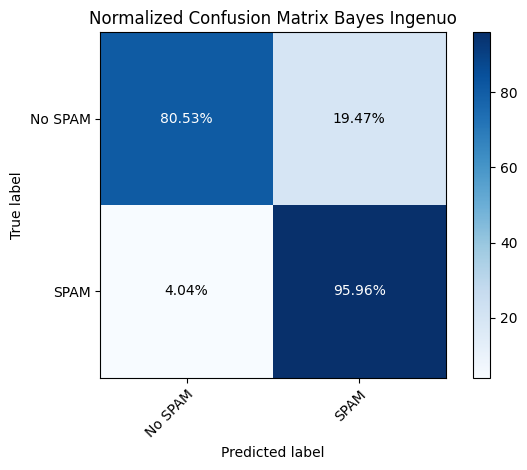

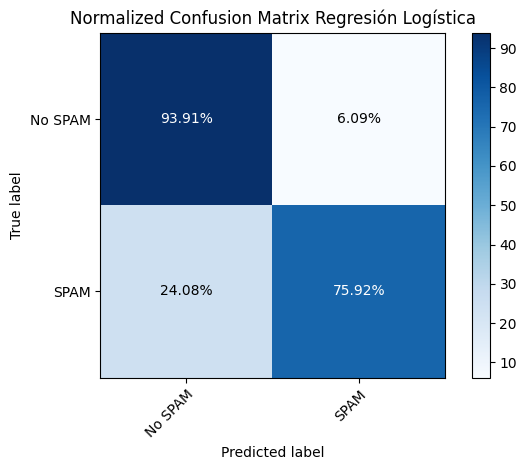

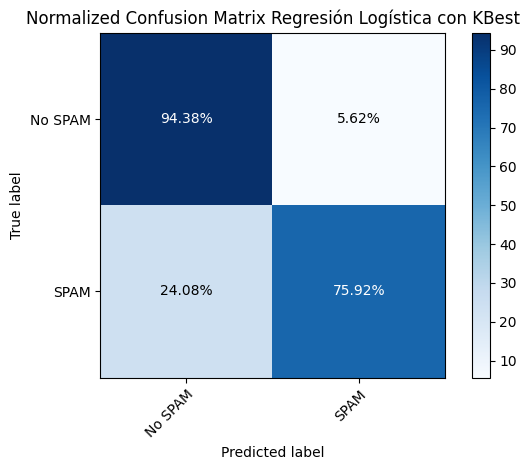

In [146]:
cm = confusion_matrix(y_test, y)
cm_nb = confusion_matrix(y_test, y_test_pred_bn)
cm_rl = confusion_matrix(y_test, y_test_pred_rl)

display_cm_normalized(cm_nb, 'Bayes Ingenuo')
display_cm_normalized(cm_rl, "Regresión Logística")
display_cm_normalized(cm, 'Regresión Logística con KBest')

**MultinommialNB**

En primer lugar, vemos la curva ROC para el modelo MultinomialNB. Al tener una menor AUC, tiene mayores dificultades para diferenciar entre clases. Por otro lado, y dada la naturaleza de este problema, donde nos importa especialmente minimizar el error de tipo 1 (falsos positivos, dado que el costo de no recibir un mail importante dado que se clasifica como spam se considera mayor que el caso contrario) vemos que tenemos un precision bajo, lo que se confirma en la matriz de confusion donde tenemos casi un 20% de muestras clasificadas como SPAM que no lo eran.

Podemos entender la baja performance de este modelo y la característica de la curva ROC (donde da probabilidades extremas muy altas o muy bajas generando variación lineal por momentos) debido a que, como se observa en el heatmap de correlaciones, no se cumple algo que este modelo da por hecho, que es la independencia entre features.

Dicho lo anterior, el accuracy se mantiene similar al resto, por eso la importancia no radica en la tasa de acierto solamente sino  **EN DONDE** fuimos mas precisos y de que tipo fueron nuestros errores.

**Regresión Logística**

La regresión logística tiene una mayor AUC, lo que indica más capacidad para diferenciar entre clases SPAM/NO SPAM. Por otro lado, tiene mayor precision, lo que nos permite minimizar el error que mas impacta manteniendo un accuracy similar.

Se observa sesgo en la clase mayoritaria y menor performance en la minoritaria debido al desbalance de clases.

**Regresión Logística KBase**

Para esta tercer variante, se utiliza KBase para tratar de eliminar features que tengan nula o escasa correlación con la varianza del target, entendiendo que podrían confundir al modelo o dar información innecesaria. Se observa una mejor (baja) tanto en precision como en el accuracy en general. Se hace una búsqueda del k optimo que maximiza el accuracy en predicción.

Se observa sesgo en la clase mayoritaria y menor performance en la minoritaria debido al desbalance de clases.

| Modelo                        |    AUC   | Accuracy | F1-score | Recall | Precision |
|-------------------------------|----------|----------|----------|--------|-----------|
| Bayes Ingenuo                | 0.8825   | 86.60%   | 0.85     | 0.96   | 0.76      |
| Regresión Logística           | 0.9409   | 86.82%   | 0.82     | 0.76   | 0.89      |
| Regresión Logística KBest     | 0.9400   | 87.11%   | 0.82     | 0.76   | 0.90      |


## Evaluación extra de escalados

### Bayes Ingenuo con MinMax y Regresión Logística con Standard

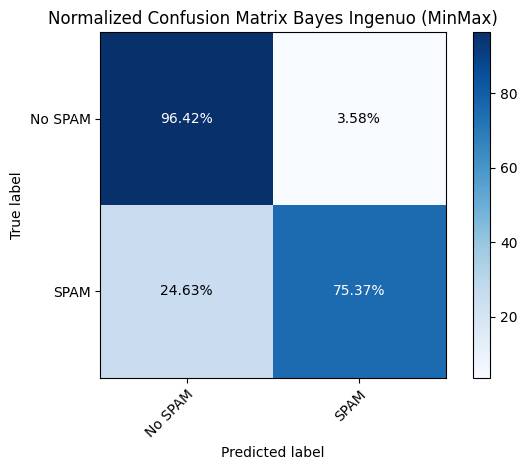

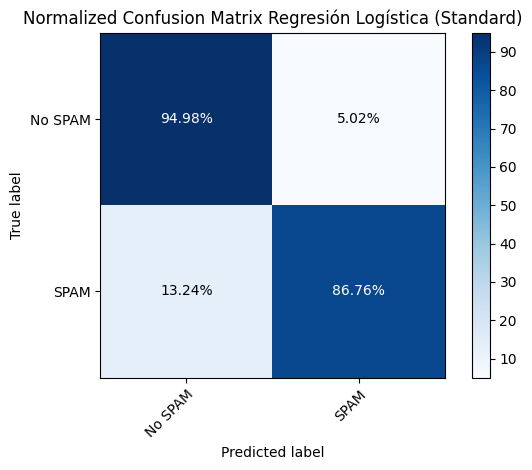

Modelo Bayes Ingenuo AUC: 0.9513559456040481
Accuracy of MultinomialNB model: 88.12%
F1-score of MultinomialNB model: 0.83
Recall of MultinomialNB model: 0.75
Precision of MultinomialNB model: 0.93
--------
Modelo Regresión Logística AUC: 0.9710099093400801
Accuracy of Regresion Logistica model: 91.75%
F1-score of Regresion Logistica model: 0.89
Recall of Regresion Logistica model: 0.87
Precision of Regresion Logistica model: 0.92


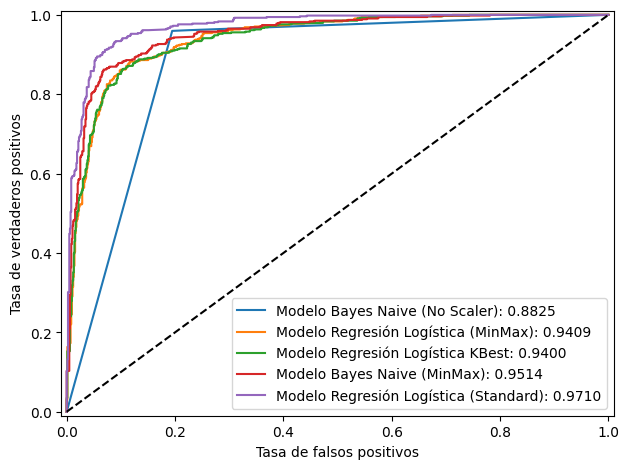

In [147]:
dataset = pd.read_csv("dataset/spambase.csv")
X = (dataset.drop(columns="spam") * 100).astype(int)
y = dataset["spam"]
random_state = 12345
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y, shuffle=True)

scaler = MinMaxScaler() 
X_train_scaled_nb = scaler.fit_transform(X_train)
X_test_scaled_nb = scaler.transform(X_test)

scaler = StandardScaler()
X_train_scaled_lg = scaler.fit_transform(X_train)
X_test_scaled_lg = scaler.transform(X_test)

bayes_naive = MultinomialNB()
bayes_naive.fit(X_train_scaled_nb, y_train)   

regresion_logistica = LogisticRegression()
regresion_logistica.fit(X_train_scaled_lg, y_train) 

y_nb_predict = bayes_naive.predict(X_test_scaled_nb)
y_regresion_logistica_predict = regresion_logistica.predict(X_test_scaled_lg)

y_nb_accuracy = accuracy_score(y_test, y_nb_predict)
y_nb_f1 = f1_score(y_test, y_nb_predict)
y_nb_recall = recall_score(y_test, y_nb_predict)
y_nb_precision = precision_score(y_test, y_nb_predict, zero_division=0, pos_label=1)

y_regresion_logistica_accuracy = accuracy_score(y_test, y_regresion_logistica_predict)
y_regresion_logistica_f1 = f1_score(y_test, y_regresion_logistica_predict)
y_regresion_logistica_recall = recall_score(y_test, y_regresion_logistica_predict)
y_regresion_logistica_precision = precision_score(y_test, y_regresion_logistica_predict, zero_division=0, pos_label=1)

cm_nb = confusion_matrix(y_test, y_nb_predict)
cm_rl = confusion_matrix(y_test, y_regresion_logistica_predict)

display_cm_normalized(cm_nb, 'Bayes Ingenuo (MinMax)')
display_cm_normalized(cm_rl, "Regresión Logística (Standard)")

prob_nb = bayes_naive.predict_proba(X_test_scaled_nb)[:, -1]
prob_lg = regresion_logistica.predict_proba(X_test_scaled_lg)[:, -1]

frp_bayes_naive_no_scaler = fpr_bayes_naive
tpr_bayes_naive_no_scaler = tpr_bayes_naive

fpr_regresion_logistica_minmax = fpr_regresion_logistica
tpr_regresion_logistica_min_max = tpr_regresion_logistica

fpr_bayes_naive, tpr_bayes_naive, _ = roc_curve(y_test, prob_nb)
fpr_regresion_logistica, tpr_regresion_logistica, _ = roc_curve(y_test, prob_lg)


print(f"Modelo Bayes Ingenuo AUC: {auc(fpr_bayes_naive, tpr_bayes_naive)}")
print(f"Accuracy of MultinomialNB model: {y_nb_accuracy * 100:.2f}%")
print(f"F1-score of MultinomialNB model: {y_nb_f1:.2f}")
print(f"Recall of MultinomialNB model: {y_nb_recall:.2f}")
print(f"Precision of MultinomialNB model: {y_nb_precision:.2f}")
print('--------')
print(f"Modelo Regresión Logística AUC: {auc(fpr_regresion_logistica, tpr_regresion_logistica)}")
print(f"Accuracy of Regresion Logistica model: {y_regresion_logistica_accuracy * 100:.2f}%")
print(f"F1-score of Regresion Logistica model: {y_regresion_logistica_f1:.2f}")
print(f"Recall of Regresion Logistica model: {y_regresion_logistica_recall:.2f}")
print(f"Precision of Regresion Logistica model: {y_regresion_logistica_precision:.2f}")


plt.plot(frp_bayes_naive_no_scaler, tpr_bayes_naive_no_scaler, label=f"Modelo Bayes Naive (No Scaler): {auc(frp_bayes_naive_no_scaler, tpr_bayes_naive_no_scaler):.4f}")
plt.plot(fpr_regresion_logistica_minmax, tpr_regresion_logistica_min_max, label=f"Modelo Regresión Logística (MinMax): {auc(fpr_regresion_logistica_minmax, tpr_regresion_logistica_min_max):.4f}")
plt.plot(fpr, tpr, label=f"Modelo Regresión Logística KBest: {auc(fpr, tpr):.4f}")
plt.plot(fpr_bayes_naive, tpr_bayes_naive, label=f"Modelo Bayes Naive (MinMax): {auc(fpr_bayes_naive, tpr_bayes_naive):.4f}")
plt.plot(fpr_regresion_logistica, tpr_regresion_logistica, label=f"Modelo Regresión Logística (Standard): {auc(fpr_regresion_logistica, tpr_regresion_logistica):.4f}")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.legend()
plt.tight_layout();

| Modelo                        |    AUC   | Accuracy | F1-score | Recall | Precision |
|-------------------------------|----------|----------|----------|--------|-----------|
| Bayes Ingenuo                | 0.8825   | 86.60%   | 0.85     | 0.96   | 0.76      |
| Regresión Logística           | 0.9409   | 86.82%   | 0.82     | 0.76   | 0.89      |
| Regresión Logística KBest     | 0.9400   | 87.11%   | 0.82     | 0.76   | 0.90      |
| Bayes Ingenuo  (MinMax)       | 0.9513   | 88.12%   | 0.83     | 0.75   | 0.93      |
| Regresión Logística (Standard) | 0.971   | 91.75%   | 0.89     | 0.87   | 0.92      |

El cambio del escalado favorece a ambos modelos. 
* En el caso de del Bayesiano, mejora notablemente en la clasificación sobre todo mejorando en los errores tipo 1. Ademas mejora en el cálculo de probabilidades como podemos ver en la ROC y ya no solo 3 valores de probabilidad distintos. Aunque MultinomialNB no requiere que los datos sean estrictamente de conteos enteros, los datos escalados con MinMaxScaler siguen manteniendo la relación positiva y directa entre las características y las etiquetas. Esto facilita que el modelo interprete los datos de manera coherente, y no altere los pesos relativos de las características
  
* El modelo logistico si se ve beneficiado en la clasificación al escalar con StandardScaler respecto al caso de MinMax